# TLIA: Time-Series Forecasting Model using Long Short-Term Memory Integrated with Artificial Neural Networks for Volatile Energy Markets 

In [8]:
from platform import python_version
print(python_version())

3.9.16


In [9]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [10]:
import numpy
print(numpy.__version__)

1.22.4


In [1]:
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
#from plotly.offline import init_notebook_mode

from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer


import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd
import time
import seaborn as sn

#init_notebook_mode(connected=True)
%matplotlib inline

# ETR methods

In [3]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  #q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = X)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[1])]+['class']

  return df

In [4]:
def first_step(X, orgin, numComponents):

  # Calculate the covariance matrix first
  X = X.astype(np.float32)
  orgin = orgin.astype(np.float32)
  correlation_matrix = np.corrcoef(orgin.T)
 
  covariance_matrix = np.cov(X.T)   # The result is a Positive semidefinite matrix
  
  final_matrix = covariance_matrix - correlation_matrix
  
  # Eigendecomposition of the covariance
  eigen_values, eigen_vectors = np.linalg.eig(final_matrix)
  # Calculate the variance explained on each of those components
  variance_explained = [(i/sum(eigen_values))*100 for i in eigen_values]
  # Calculate the cumulative sum of variance explained
  cumulative_variance_explained = np.cumsum(variance_explained)
  #Taking two components and create a projection matrix
  projection_matrix = (eigen_vectors.T[:][:numComponents]).T
  
  # Calculate the product of X (standardized original data multiply by eigenvectors)

  X_w = X.dot(projection_matrix)

  return X_w

In [5]:
def ETR(X1, y1, status = 'max', min_no = 1, numComponents=15):
  scaler=[]
  y = []

  df = extract_pixels(X1, y1)
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]
  
  X = first_step(X,X, numComponents)

  # the second step of the ETR method
  X_mean = X
  X_mean['mean'] = X_mean.max(axis=1)* min_no

  Avr = [X_mean['mean']]
  rep_Avr = np.repeat(Avr, numComponents)
  rep_Avr =np.reshape(rep_Avr, (-1,numComponents))
  main_X = X.iloc[:, :-1]
  seed = main_X - rep_Avr
  
  dilated = reconstruction(seed.values, main_X.values)    
  #print(dilated)
  scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
  scaler = scaler.fit_transform(dilated)
  
  return scaler, y 

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

# The TLIA model

<ipython-input-7-b0af2760b6d6>:24: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


(2105, 60) (2105,)
(2105, 60) (2105,)
dataset1 =  (2105, 61)
train_scaled =  (1684, 61)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 60, 1)                24        
                                                                 
 dense_3 (Dense)             (1, 60, 1)                2         
                                                                 
 dropout_6 (Dropout)         (1, 60, 1)                0         
                                                                 
 dense_4 (Dense)             (1, 60, 1)                2         
                                                                 
 dropout_7 (Dropout)         (1, 60, 1)                0         
                                                                 
 dense_5 (Dense)             (1, 60, 1)                2         
                                

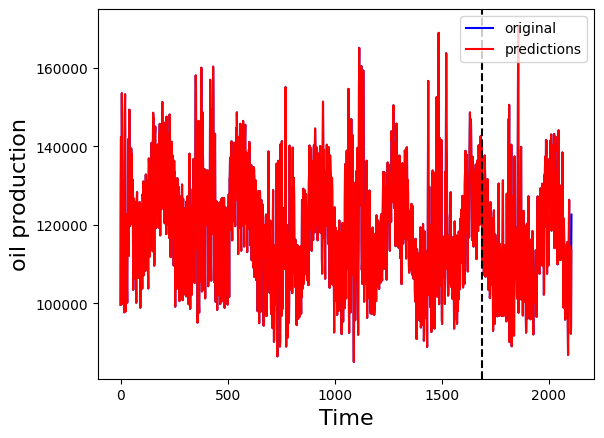

In [7]:
import numpy as np
import tensorflow.compat.v1 as tf
import random as rn
import numpy as np
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, LSTM
from keras.layers import SimpleRNN
from keras.constraints import max_norm
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
from sklearn.metrics import r2_score
import time

def parser(x):
	return datetime.strptime(x, '%Y%m')

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train.iloc[:, 0:-1].values, train.iloc[:, -1].values
	X = X.reshape(X.shape[0], X.shape[1],1 )
	X = np.asarray(X).astype('float32')
	y = np.asarray(y).astype('float32')
	model1 = Sequential()
	model1.add(LSTM(neurons[0], batch_input_shape=(batch_size, X.shape[1], X.shape[2]) , stateful=True,return_sequences = True))
	model1.add(Dropout(0.3))
	model1.add(LSTM(neurons[1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences = True))
	model1.add(Dropout(0.3))

	# Freeze the base model
	model1.trainable = False
	model = Sequential()
	model.add(model1)
	model.add(Dense(neurons[0], activation = 'relu', input_dim=(60)))
	model.add(Dropout(0.3))
	model.add(Dense(neurons[1], activation = 'relu', input_dim=(60)))
	model.add(Dropout(0.3))
 
	model.add(Dense(1))
       
	model.compile(loss='mean_squared_error', optimizer='adam')

	print(model.summary())
 
	for i in range(nb_epoch):
		print('Epoch:',i)
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model
	


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, len(X), 1)
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


# Update LSTM model
def update_model(model, train, batch_size, updates):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], X.shape[1],1 )
	for i in range(updates):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataset = np.insert(dataset,[0]*look_back,0)    
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	dataY= np.array(dataY)        
	dataY = np.reshape(dataY,(dataY.shape[0],1))
	dataset = np.concatenate((dataX,dataY),axis=1)  
	return dataset


# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result




def experiment(series,look_back,neurons,n_epoch, dset):

	raw_values = series.values
	# transform data to be stationary
	diff = difference(raw_values, 1)

	# create dataset x,y
	dataset = diff.values
	dataset = create_dataset(dataset,look_back)

	X = dataset[:,:-1]
	y11 = dataset[:, -1]
	df = extract_pixels(X, y11)
	X = df.iloc[:, :-1]
	y = df.iloc[:, -1]

	numComponents = 60
	test_ratio = 0.2
	#windowSize = 15
	h1 = X.shape[0]
	w1 = X.shape[1]
	print(X.shape, y.shape)
	status = 'max' #'mean' or 'max' choosing the status is used to enhance classes' variation.
	sigma = 0.30 # σ is used to reduce the distance between values of the same class.

	X1, y1 = ETR(X,y, status, sigma, numComponents)
	print(X1.shape, y1.shape)

	fff = pd.DataFrame(data = X1)
	ffff = pd.concat([fff, pd.DataFrame(data = y1.ravel())], axis=1)
	dataset1 = ffff 

	print("dataset1 = ",dataset1.shape)

	# split into train and test sets
	train_size = int(dataset1.shape[0] * 0.8)
	test_size = dataset1.shape[0] - train_size
	train, test = dataset1[0:train_size], dataset1[train_size:]

	train_scaled = train
	test_scaled = test
	print("train_scaled = ",train_scaled.shape)
	# fit the model
	training_start_time = time.time()

	lstm_model = fit_lstm(train_scaled, 1, n_epoch, neurons)
    
	training_end_time = time.time()
    
	# forecast the entire training dataset to build up state for forecasting
	predictions_train = list()
    
	for i in range(len(train_scaled)):
		# make one-step forecast train_scaled[i, 0:-1], train_scaled[i, -1]
		X, y = train_scaled.iloc[i, 0:-1], train_scaled.iloc[i, -1]
		#X = X.reshape(X.shape[0], X.shape[1],1 )
		X = np.asarray(X).astype('float32')
		y = np.asarray(y).astype('float32')
 
		#X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)

		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(raw_values)-i)
		# store forecast
		predictions_train.append(yhat)
		expected = raw_values[ i+1 ] 

	predictions_test = list()
	test_start_time = time.time()
	for i in range(len(test_scaled)):
		X, y = test_scaled.iloc[i, 0:-1], test_scaled.iloc[i, -1]
		X = np.asarray(X).astype('float32')
		y = np.asarray(y).astype('float32')

		yhat = forecast_lstm(lstm_model, 1, X)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions_test.append(yhat)
		expected = raw_values[len(train) + i + 1]
	test_end_time = time.time()
    
	# report performance

	# forecast the test data
	print("Training time : ", training_end_time - training_start_time )
	print("Testing time : ", test_end_time - test_start_time)
    
	print('Forecasting Training Data')
	rmse_train = sqrt(mean_squared_error(raw_values[:len(train_scaled),:], predictions_train))
	print('Train RMSE: %.3f' % rmse_train)
	#report performance using RMSPE
	rmspe_train = RMSPE(raw_values[:len(train_scaled),:],predictions_train)
	print('Train RMSPE: %.3f' % rmspe_train)
	MAE_train = mean_absolute_error(raw_values[:len(train_scaled),:], predictions_train)
	print('Train MAE: %.5f' % MAE_train)
	MAPE_train = MAPE(raw_values[:len(train_scaled),:], predictions_train)
	print('Train MAPE: %.5f' % MAPE_train)
	r2 = r2_score(raw_values[:len(train_scaled),:], predictions_train)
	print('r2 score for training model is', r2)
  # report performance using RMSE
	print("raw_values = ", raw_values.shape,test_scaled.shape[0])

	print('Forecasting Testing Data')
	dd = raw_values.shape[0]-1

	rmse_test = sqrt(mean_squared_error(raw_values[train_scaled.shape[0]:dd,:], predictions_test))
	print('Test RMSE: %.3f' % rmse_test)
	#report performance using RMSPE
	rmspe_test = RMSPE(raw_values[train_scaled.shape[0]:dd,:],predictions_test)
	print('Test RMSPE: %.3f' % rmspe_test)
	MAE_test = mean_absolute_error(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
	print('Test MAE: %.5f' % MAE_test)
	MAPE_test = MAPE(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
	print('Test MAPE: %.5f' % MAPE_test)
	r22 = r2_score(raw_values[train_scaled.shape[0]:dd,:], predictions_test)
	print('r2 score for testing model is', r22)

	predictions = np.concatenate((predictions_train,predictions_test),axis=0)

	fc_report = pd.DataFrame(predictions_test)
	fc_report.to_csv(dset + ' ETR LSTM_ANN.csv', index= True)		
	fc_report2 = pd.DataFrame(predictions)
	fc_report2.to_csv(dset + ' All ETR LSTM_ANN.csv', index= True)		
 
	file_name = dset+"results of ETR LSTM_ANN.txt"
	with open(file_name, 'w') as x_file:
		x_file.write('RMSE: ')
		x_file.write('\n')
		x_file.write('RMSPE: ')
		x_file.write('\n')
		x_file.write('MAE: ')
		x_file.write('\n')
		x_file.write('MAPE: ')
		x_file.write('\n')
		x_file.write('R2: ')
		x_file.write('\n')
		x_file.write('{} Training time (S): '.format(training_end_time - training_start_time))
		x_file.write('\n')
		x_file.write('{} Testing time (S): '.format(test_end_time - test_start_time))
		x_file.write('\n')
		x_file.write('Forecasting Training Data: ')
		x_file.write('\n')
		x_file.write('{}'.format(rmse_train))
		x_file.write('\n')
		x_file.write('{}'.format(rmspe_train))
		x_file.write('\n')
		x_file.write('{}'.format(MAE_train))
		x_file.write('\n')
		x_file.write('{}'.format(MAPE_train))
		x_file.write('\n')
		x_file.write('{}'.format(r2))
		x_file.write('\n')

		x_file.write('Forecasting Testing Data: ')
		x_file.write('\n')
		x_file.write('{}'.format(rmse_test))
		x_file.write('\n')
		x_file.write('{}'.format(rmspe_test))
		x_file.write('\n')
		x_file.write('{}'.format(MAE_test))
		x_file.write('\n')
		x_file.write('{}'.format(MAPE_test))
		x_file.write('\n')
		x_file.write('{}'.format(r22))
		x_file.write('\n')
		
    
    # line plot of observed vs predicted
	fig, ax = plt.subplots(1)
	ax.plot(raw_values, label='original', color='blue')
	ax.plot(predictions, label='predictions', color='red')
	ax.axvline(x=len(train_scaled)+1,color='k', linestyle='--')
	ax.legend(loc='upper right')
	ax.set_xlabel("Time",fontsize = 16)
	ax.set_ylabel('oil production',fontsize = 16)
	plt.show()
	 

	 

def run():
	series = read_csv('demand.csv')
	dset = 'demand'
	look_back= 60 #2
	neurons=[ 1 , 1 ]
	n_epoch=5
	experiment(series,look_back,neurons,n_epoch, dset)

run()

